## Keras ConvNet Example
This example network is an update of the network from the [ipynb playground](https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist_v1.ipynb).  The changes are to ugrade the Keras calls to keras v2 and a tensorflow backend.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import numpy as np
np.random.seed(1337) # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils


Using TensorFlow backend.


In [2]:
np.set_printoptions(precision=5, suppress=True)


In [3]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
#X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


label :  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


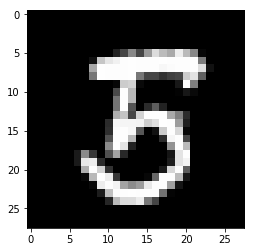

In [4]:
i = 4600
print("label : ", Y_train[i,:])
sample = X_train[i, ...]
sample.shape
pl.imshow(X_train[i,:, :, 0], interpolation='nearest', cmap=cm.gray)
pl.show()

In [5]:
model = Sequential()

convout1 = Conv2D(32, (3, 3), strides=(1, 1), padding='same', input_shape=(28, 28, 1), activation='relu')
model.add(convout1)

convout2 = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [8]:
import os
import h5py
WEIGHTS_FNAME = 'mnist_cnn_weights_v1.hdf'
if True and os.path.exists(WEIGHTS_FNAME):
    # Just change the True to false to force re-training
    print('Loading existing weights')
    model.load_weights(WEIGHTS_FNAME)
else:
    batch_size = 128
    nb_epoch = 3
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
              verbose=1, validation_data=(X_test, Y_test))
#    model.save_weights(WEIGHTS_FNAME, overwrite=True)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 376s 6ms/step - loss: 1.6291 - acc: 0.4307 - val_loss: 1.1761 - val_acc: 0.6302
Epoch 2/3
60000/60000 [==============================] - 350s 6ms/step - loss: 1.6246 - acc: 0.4380 - val_loss: 1.0726 - val_acc: 0.6692
Epoch 3/3
60000/60000 [==============================] - 8456s 141ms/step - loss: 1.6238 - acc: 0.4404 - val_loss: 1.1593 - val_acc: 0.6808
Test score: 1.15934333897
Test accuracy: 0.6808


In [9]:
np.set_printoptions(precision=3, suppress=True)
print(model.predict(X_test[1:5]))
print(Y_test[1:5])

Y_pred = model.predict(X_test)
# Convert one-hot to index
y_pred = np.argmax(Y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


[[ 0.     0.     1.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.425  0.     0.     0.     0.     0.575]]
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]
             precision    recall  f1-score   support

          0       0.96      0.95      0.95       980
          1       0.98      0.95      0.96      1135
          2       0.95      0.79      0.86      1032
          3       0.96      0.76      0.85      1010
          4       0.00      0.00      0.00       982
          5       0.16      0.01      0.02       892
          6       0.98      0.76      0.85       958
          7       0.99      0.70      0.82      1028
          8       0.33      0.95      0.49       974
   

In [10]:
# Visualize a convolved image
from keras import backend as K

# K.learning_phase() is a flag that indicates if the network is in training or
# predict phase. It allow layer (e.g. Dropout) to only be applied during training
inputs = [K.learning_phase()] + model.inputs

_convout1_f = K.function(inputs, [convout1.output])
def convout1_f(X):
    # The [0] is to disable the training phase flag
    return _convout1_f([0] + [X])

In [11]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

(1, 28, 28, 1)


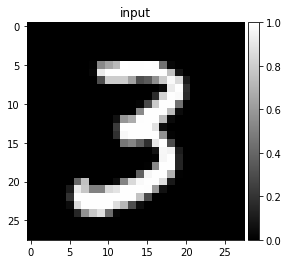

In [12]:
i = 4600

# Visualize the first layer of convolutions on an input image
X = X_test[i:i+1]
print(X.shape)
X.reshape(28, 28)
pl.figure()
pl.title('input')
nice_imshow(pl.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.gray)
pl.show()

In [36]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[2]
    print(nimgs)
    imshape = imgs.shape[:2]
    print(imshape)
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:, :,i]
    return mosaic


9
<class 'keras.layers.convolutional.Conv2D'>
W shape :  (3, 3, 32)
32
(3, 3)


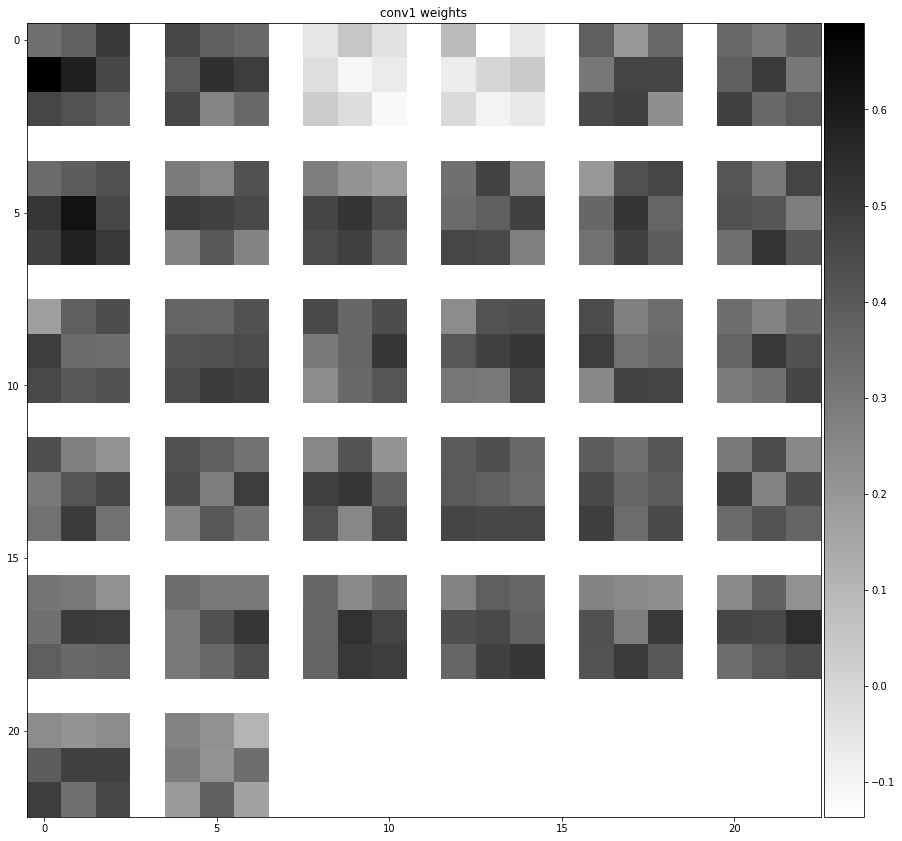

In [38]:
# Visualize weights
print(len(model.layers))
print(type(model.layers[0]))
#print(model.layers[0].get_weights()[0])
W = model.layers[0].get_weights()[0]
W = np.squeeze(W)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), make_mosaic(W, 6, 6), cmap=cm.binary)
pl.show()

C1 shape :  (28, 28, 32)
32
(28, 28)


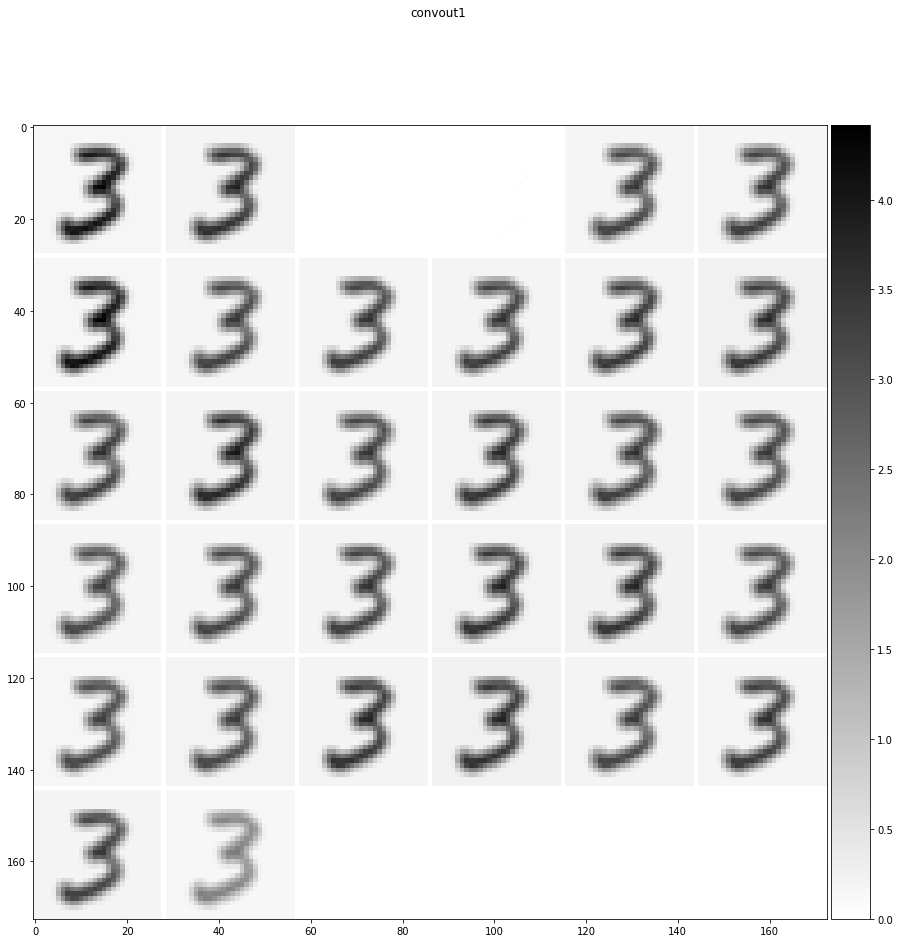

In [41]:
# Visualize convolution result (after activation)
C1 = convout1_f(X)
C1 = np.squeeze(C1)
print("C1 shape : ", C1.shape)

pl.figure(figsize=(15, 15))
pl.suptitle('convout1')
nice_imshow(pl.gca(), make_mosaic(C1, 6, 6), cmap=cm.binary)
pl.show()

img 2 and 3 are blank why?  wierd.  further investigation required!!